# このノートは？

- chainer のexamples (公式のサンプル)を使って, 流れを理解する
- 研究の準備として, 以下の問題について取り組む
    1. `[0, 100](%)` の混用率データを10 % 刻みに分類する
    2. 回帰問題について, 挑戦する.

# 使い方

1. まず`A.モジュールの読み込み` と`B. Define Network: MLP` のセルを実行する
2. 続いて, 取り組むべき項目に進む

# 説明を省略してる事

ググるなり, 書籍で勉強してください。

- 損失関数について; 評価をしている関数
    - 分類問題では, Softmax Cross Entropy 関数がよく使われます
    - 回帰問題では, Mean Square Loss(MSE) 関数などが使われます

# A. モジュールの読み込み

In [3]:
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples
from pylab import *

import pandas
import numpy

%matplotlib inline


# B. Define Network 

簡単な, 多層パーセプトロンです。

In [5]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

# 0. example/mnist/

手書き文字の分類をします.

## 0.1. 使うネットワークの指定と解くべきモデルを定義します

In [7]:
net = MLP(1000, 10)
model = L.Classifier(net)



## 0.2. 最適化について設定します。
chainer では以下のURL 先にあるような最適化手法を利用する事ができます。

https://docs.chainer.org/en/stable/reference/optimizers.html

ここでは, Adam を使用しています。原理は以下の論文を参照する.

https://arxiv.org/abs/1412.6980v8

In [8]:
optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer.setup(model)

## 0.3. 解析データの準備
### 0.3.A
まず, 1行目ではMNIST を多分以下のURL 先からダウンロードし, /多分ホームディレクトリ/.chainer 配下に保存される. せっかくなので, MNIST とは何かを見ておくといいと思います。

http://yann.lecun.com/exdb/mnist/

2行目以降では, モデルの学習で呼び出すためのイテレータ形式で用意しています.


In [18]:
train, test = chainer.datasets.get_mnist()
train_iter = chainer.iterators.SerialIterator(train, 1000)
test_iter = chainer.iterators.SerialIterator(test, 1000, repeat=False, shuffle=False)




### 0.3.B 中身の確認

ここは, example/mnist に無い処理で, 中身の確認をしています

784
8


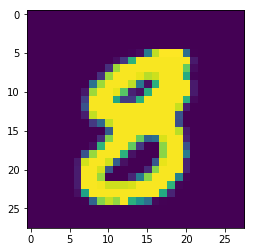

In [12]:
train_iter.reset()
tmp = train_iter.next()[0]

print(len(tmp[0]))
%matplotlib inline
from pylab import *
imshow(tmp[0].reshape(28, 28))
print(tmp[1])

## 0.4. 学習の設定

In [21]:
# イタレータの初期化です
train_iter.reset()
test_iter.reset()

# ----------------------------

# 学習回数
# iteration 回数(パラメータの更新回数)でも指定できます
epoch = 1

# GPU を使うか否か; 
gpu = -1


# 学習sequence の初期化
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu)
trainer = training.Trainer(updater, (epoch, 'epoch'), out="./Result20180612")

# 検証の設定です: 訓練したモデルに対して, 検証データを代入して評価します.
# 毎epoch (ないし, iteration)で計算されます
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))

# 使ったネットワークを画像化するための, dot 形式のファイルを出力する設定です.
# graphviz というグラフ作成
# ここでいうグラフは, 折れ線グラフとか散布図グラフの"グラフ"でなく, 
# ノードやエッジの集合で表す"グラフ"です.
trainer.extend(extensions.dump_graph('main/loss'))


# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# loss(損失) Plotの設定
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

# accuracy(分類精度) Plotの設定
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# 標準出力で, どの項目を出力させるかの設定です.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# 0.5. 学習

In [22]:
#     if args.resume:
#         # Resume from a snapshot
#         chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.0752923   0.0844654             0.977267       0.9741                    12.0917       


# 0.6. 答え合わせ
## 0.6.A 学習済みモデルでの検証
訓練したネットワークに, 検証データを代入し, 正しく分類できているかを確認します.

[[-5.8260827 -6.654916  -4.0141077 -1.6780964  1.08317   -0.6150677
  -6.7935443 -3.5463493  2.7270257  4.2244596]]


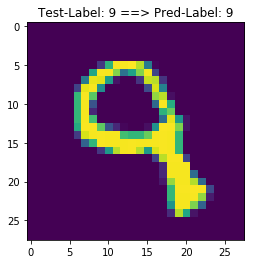

In [42]:
net.to_cpu()

# test_iter.reset()
tmp = test_iter.next()[int(numpy.random.rand())]

%matplotlib inline
ans = numpy.argmax(net(tmp[0].reshape(1, 784)).data)
fig, ax = matplotlib.pyplot.subplots(1, 1)
ax.imshow(tmp[0].reshape(28, -1))
ax.set_title("Test-Label: %s ==> Pred-Label: %s" % (tmp[1], ans))


# 順伝搬出力
print(net(tmp[0].reshape(1, 784)).data)



# 0.6.B 本当に学習できてるのか?

学習前のネットワークを定義して, 学習前で本当に分類できないかを確認する.

[[ -6.2222576  -7.4565215  -5.067435   -1.7984313   0.2752015  -2.5184677
  -11.301038    1.3011961  -3.1755087   8.495049 ]]


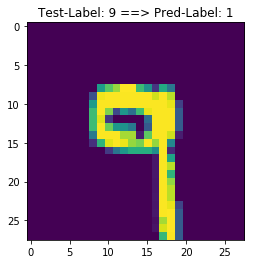

In [44]:
netB = MLP(1000, 10)

# test_iter.reset()
tmp = test_iter.next()[int(numpy.random.rand())]

%matplotlib inline
ans = numpy.argmax(netB(tmp[0].reshape(1, 784)).data)
fig, ax = matplotlib.pyplot.subplots(1, 1)
ax.imshow(tmp[0].reshape(28, -1))
ax.set_title("Test-Label: %s ==> Pred-Label: %s" % (tmp[1], ans))


# 順伝搬出力
print(net(tmp[0].reshape(1, 784)).data)



# 1. 混用率データを10クラスに分類
## 1.1. モデルの定義

In [45]:
# network の定義

net_cp = MLP(5000, 10)
model = L.Classifier(net_cp)

# optimizer
optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer.setup(model)

## 1.2. Excel ファイルの読み込み

Pandas を使って, Excel ファイルを読み込みます.

In [47]:
# xls = pandas.read_excel("/home/fiber_classifier/Desktop/FY2017to2018_twada/00_Data/MixtureRate/CP.xls")
xls = pandas.read_excel("/Users/twada/Data/DC2016to2019/MixingRateForMonglian_H28/CP.xls")

In [55]:
arr = xls.as_matrix()  # pandas.DataFrame 型 ==> numpy.ndarray 型; 解析データ部分の抽出
# print(arr)

# スペクトルデータと参照値(ラベル情報)を分離する
data = arr[:-1]
ref = arr[-1]
# data.shape

In [57]:
# 参照値のList から, 0, 9までの10 段階のラベル-List を生成する

list_ref = []
for v in ref:
    list_ref.append(round(v/10))
label = numpy.array(list_ref, dtype=numpy.int)


## 1.3. 解析データの準備

まず, 1行目ではMNIST を多分以下のURL 先からダウンロードし, /多分ホームディレクトリ/.chainer 配下に保存される. せっかくなので, MNIST とは何かを見ておくといいと思います。

http://yann.lecun.com/exdb/mnist/

2行目以降では, モデルの学習で呼び出すためのイテレータ形式で用意しています.


In [58]:
x_train, y_train = data[:,:100].astype(numpy.float32), label[:100]
x_test, y_test = data[:,100:].astype(numpy.float32), label[100:]

train = tuple_dataset.TupleDataset(x_train.T, y_train)
test = tuple_dataset.TupleDataset(x_test.T, y_test)


train_iter = chainer.iterators.SerialIterator(train, 10)
test_iter = chainer.iterators.SerialIterator(test, 28, repeat=False, shuffle=False)

In [59]:
# イタレータの初期化です
train_iter.reset()
test_iter.reset()

# ----------------------------

# 学習回数
# iteration 回数(パラメータの更新回数)でも指定できます
epoch = 1

# GPU を使うか否か; 
gpu = -1


# 学習sequence の初期化
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu)
trainer = training.Trainer(updater, (epoch, 'epoch'), out="./Result20180612")

# 検証の設定です: 訓練したモデルに対して, 検証データを代入して評価します.
# 毎epoch (ないし, iteration)で計算されます
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))

# 使ったネットワークを画像化するための, dot 形式のファイルを出力する設定です.
# graphviz というグラフ作成
# ここでいうグラフは, 折れ線グラフとか散布図グラフの"グラフ"でなく, 
# ノードやエッジの集合で表す"グラフ"です.
trainer.extend(extensions.dump_graph('main/loss'))


# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# loss(損失) Plotの設定
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

# accuracy(分類精度) Plotの設定
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# 標準出力で, どの項目を出力させるかの設定です.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

In [60]:
# 学習開始
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           23.5425     1.86069               0.12           0.037037                  8.35071       


# 1.4. 答え合わせ

3
Output of forward propagation
[[-0.6601541  -0.98300207  0.40640348 -0.800582   -0.00879913 -0.41354418
   1.3191265   1.0131575   1.1820529  -0.42023137]]


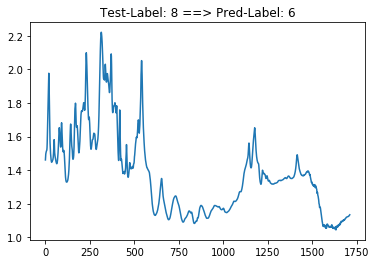

In [121]:
net.to_cpu()

test_iter.reset()
k = int(numpy.random.choice(range(27), size=1))
print(k)
tmp = test_iter.next()[k]  # 適当に1 スペクトル選びます

fig, ax = matplotlib.pyplot.subplots(1, 1)
ax.plot(tmp[0])


ans = numpy.argmax(net_cp(tmp[0].reshape(1, -1)).data)

ax.set_title("Test-Label: %s ==> Pred-Label: %s" % (tmp[1], ans))


# 順伝搬出力
print("Output of forward propagation")
print(net_cp(tmp[0].reshape(1, -1)).data)



In [150]:
test_iter.reset()

# test_batch = test_iter.next()
# test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
tmp = test_iter.next()
for k in range(27):
    spc = tmp[k][0]
    ref = tmp[k][1]
    pred = numpy.argmax(net_cp(spc.reshape(1,-1)).data)
    print("Ref: %d, Pred: %d %s" % (ref, pred, ref == pred))

Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 2, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 9, Pred: 6 False
Ref: 9, Pred: 6 False
Ref: 4, Pred: 6 False
Ref: 2, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 6, Pred: 6 True
Ref: 8, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 8, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 7, Pred: 6 False
Ref: 0, Pred: 6 False
Ref: 8, Pred: 6 False


# C. おまけ
## C.1. データのばらつき

In [156]:
print("10 %刻みの場合")
print(" ----------- ")
print(numpy.histogram(a=arr[-1], bins=10))

print("1 %刻みの場合")
print(" ----------- ")
print(numpy.histogram(a=arr[-1], bins=100))

print("5 %刻みの場合")
print(" ----------- ")
print(numpy.histogram(a=arr[-1], bins=20))

10 %刻みの場合
 ----------- 
(array([ 3,  2, 12,  6,  7,  7, 21, 26, 23, 20]), array([ 0.4 ,  9.52, 18.64, 27.76, 36.88, 46.  , 55.12, 64.24, 73.36,
       82.48, 91.6 ]))
1 %刻みの場合
 ----------- 
(array([ 1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  1,
        0,  0,  0,  2,  4,  2,  1,  1,  0,  0,  0,  0,  2,  1,  0,  1,  0,
        3,  0,  0,  0,  0,  1,  1,  2,  0,  0,  1,  0,  2,  0,  0,  1,  0,
        1,  1,  1,  2,  0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  2,  5,
        7,  6,  4, 11,  4,  1,  1,  1,  2,  1,  0,  1,  0,  1,  0,  1,  2,
        2,  3,  1,  5,  8,  7,  7,  3,  0,  0,  0,  0,  0,  1,  2]), array([ 0.4  ,  1.312,  2.224,  3.136,  4.048,  4.96 ,  5.872,  6.784,
        7.696,  8.608,  9.52 , 10.432, 11.344, 12.256, 13.168, 14.08 ,
       14.992, 15.904, 16.816, 17.728, 18.64 , 19.552, 20.464, 21.376,
       22.288, 23.2  , 24.112, 25.024, 25.936, 26.848, 27.76 , 28.672,
       29.584, 30.496, 31.408, 32.32 , 33.232, 34.144, 35.056, 35.968,
       36.

In [1]:
import numpy
import pandas
import glob
impo